# **Tugas 1**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

Dataset dimuat, bentuk: (3168, 21)
Data telah di-scale dan dibagi.

--- Bagian 1: Mencari Fitur Optimal ---
Melatih RandomForestClassifier untuk mendapatkan 'feature importance'...

Fitur diurutkan berdasarkan 'importance':
meanfun     0.317209
IQR         0.229569
Q25         0.155001
sd          0.073889
sp.ent      0.040458
sfm         0.025698
centroid    0.020650
meanfreq    0.019543
mode        0.018053
median      0.013558
Q75         0.011223
skew        0.010916
maxdom      0.010234
minfun      0.009668
mindom      0.009611
dfrange     0.009383
kurt        0.007416
meandom     0.007368
modindx     0.006044
maxfun      0.004507
dtype: float64

Menguji akurasi kNN (k=5) dengan jumlah fitur berbeda:

Plot 'feature_selection_accuracy.png' telah disimpan.

--- Hasil Seleksi Fitur ---
Akurasi tertinggi (0.9874) dicapai saat menggunakan 10 fitur teratas.
Fitur optimal yang dipilih adalah:
['meanfun', 'IQR', 'Q25', 'sd', 'sp.ent', 'sfm', 'centroid', 'meanfreq', 'mode', 'median']

--- 

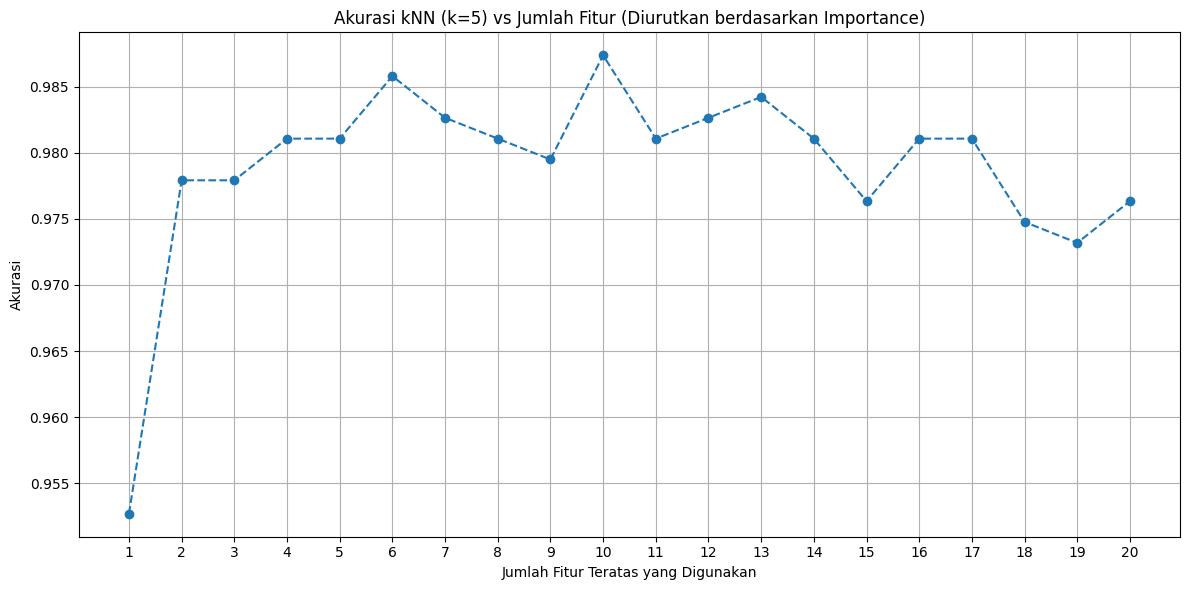

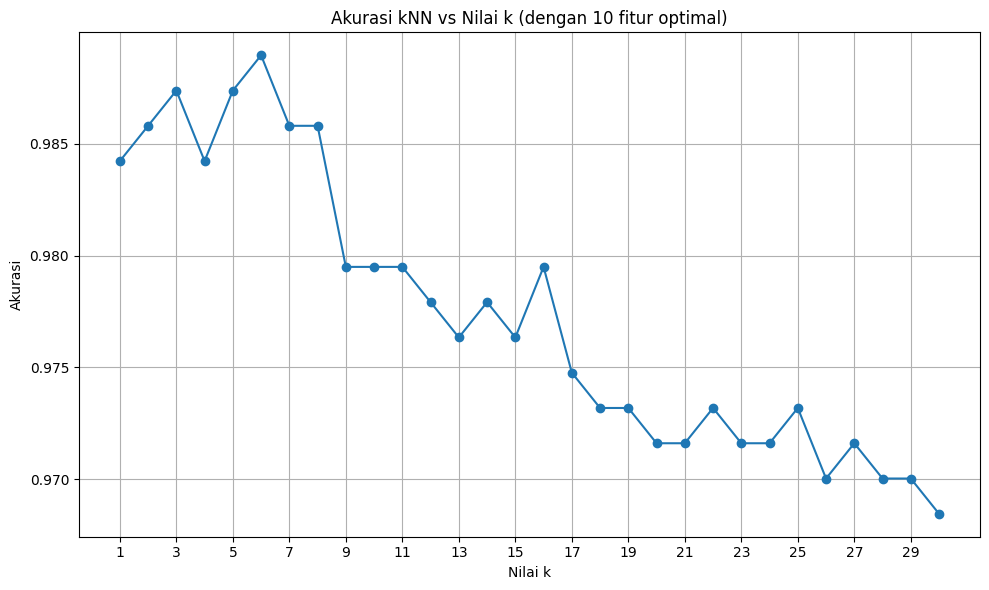

In [ ]:
# ---------------------------------------------------------------------------
# 1. Memuat dan Mempersiapkan Data
# ---------------------------------------------------------------------------
try:
    file_path = 'voice.csv'
    df = pd.read_csv(file_path)

    print(f"Dataset dimuat, bentuk: {df.shape}")
    # print(df.info())

    # Konversi label 'male'/'female' menjadi numerik (0 dan 1)
    encoder = LabelEncoder()
    df['label'] = encoder.fit_transform(df['label'])
    # 0 = female, 1 = male
    # print(df.head())

    # Pisahkan fitur (X) dan target (y)
    X = df.drop('label', axis=1)
    y = df['label']

    # ---------------------------------------------------------------------------
    # 2. Pembagian Data Latih dan Uji
    # ---------------------------------------------------------------------------
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # ---------------------------------------------------------------------------
    # 3. Feature Scaling
    # ---------------------------------------------------------------------------
    # kNN sangat sensitif terhadap skala data, jadi StandardScaler adalah wajib.
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Mengembalikan ke DataFrame agar mudah memanipulasi kolom
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

    print("Data telah di-scale dan dibagi.")

    # ---------------------------------------------------------------------------
    # TUGAS 2: Identifikasi Fitur Optimal
    # ---------------------------------------------------------------------------
    print("\n--- Bagian 1: Mencari Fitur Optimal ---")
    print("Melatih RandomForestClassifier untuk mendapatkan 'feature importance'...")

    # Kita gunakan RandomForest untuk memberi peringkat fitur
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)

    # Dapatkan 'importance' dan urutkan
    importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

    print("\nFitur diurutkan berdasarkan 'importance':")
    print(importances)

    # Sekarang, kita uji akurasi kNN (k=5) dengan menambahkan fitur satu per satu
    # berdasarkan urutan 'importance'

    sorted_feature_names = importances.index
    feature_accuracies = []

    print("\nMenguji akurasi kNN (k=5) dengan jumlah fitur berbeda:")

    for i in range(1, len(sorted_feature_names) + 1):
        # Ambil 'i' fitur teratas
        current_features = sorted_feature_names[:i]

        # Siapkan data train/test hanya dengan fitur ini
        X_train_subset = X_train_scaled[current_features]
        X_test_subset = X_test_scaled[current_features]

        # Latih model kNN (k=5)
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train_subset, y_train)

        # Prediksi dan hitung akurasi
        y_pred = knn.predict(X_test_subset)
        acc = accuracy_score(y_test, y_pred)
        feature_accuracies.append(acc)

        # print(f"Dengan {i} fitur, Akurasi: {acc:.4f}") # (Opsional: terlalu banyak)

    # Plot hasil seleksi fitur
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(X.columns) + 1), feature_accuracies, marker='o', linestyle='--')
    plt.title('Akurasi kNN (k=5) vs Jumlah Fitur (Diurutkan berdasarkan Importance)')
    plt.xlabel('Jumlah Fitur Teratas yang Digunakan')
    plt.ylabel('Akurasi')
    plt.xticks(range(1, len(X.columns) + 1))
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('feature_selection_accuracy.png')
    print("\nPlot 'feature_selection_accuracy.png' telah disimpan.")

    # Cari jumlah fitur terbaik
    best_num_features = np.argmax(feature_accuracies) + 1
    best_feature_accuracy = max(feature_accuracies)

    # Dapatkan daftar fitur optimal
    optimal_features = sorted_feature_names[:best_num_features].tolist()

    print(f"\n--- Hasil Seleksi Fitur ---")
    print(f"Akurasi tertinggi ({best_feature_accuracy:.4f}) dicapai saat menggunakan {best_num_features} fitur teratas.")
    print("Fitur optimal yang dipilih adalah:")
    print(optimal_features)

    # ---------------------------------------------------------------------------
    # TUGAS 3: Identifikasi Nilai 'k' Optimal
    # ---------------------------------------------------------------------------
    print("\n--- Bagian 2: Mencari Nilai 'k' Optimal (menggunakan fitur terpilih) ---")

    # Siapkan data hanya dengan fitur optimal
    X_train_optimal = X_train_scaled[optimal_features]
    X_test_optimal = X_test_scaled[optimal_features]

    k_range = range(1, 31) # Kita akan uji k dari 1 sampai 30
    k_scores = []

    print(f"Menguji kNN untuk k dari {k_range.start} sampai {k_range.stop-1}...")

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_optimal, y_train)
        score = knn.score(X_test_optimal, y_test)
        k_scores.append(score)

    # Plot hasil pencarian 'k'
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, k_scores, marker='o')
    plt.title(f'Akurasi kNN vs Nilai k (dengan {best_num_features} fitur optimal)')
    plt.xlabel('Nilai k')
    plt.ylabel('Akurasi')
    plt.xticks(range(1, 31, 2))
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('knn_k_selection.png')
    print("Plot 'knn_k_selection.png' telah disimpan.")

    # Cari nilai k terbaik
    best_k = k_range[np.argmax(k_scores)]
    best_k_accuracy = max(k_scores)

    print(f"\n--- Hasil Tuning 'k' ---")
    print(f"Nilai 'k' terbaik adalah {best_k}, yang menghasilkan akurasi {best_k_accuracy:.4f}.")
    print("---------------------------------")


except FileNotFoundError:
    print(f"Error: File '{file_path}' tidak ditemukan.")
except Exception as e:
    print(f"Terjadi kesalahan: {e}")